In [2]:
import numpy as np
import pandas as pd
import trajectory_planning_helpers as tph
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from f1tenth_benchmarks.utils.MapData import MapData
from f1tenth_benchmarks.utils.track_utils import RaceTrack, CentreLine
from trajectory_planning_helpers.calc_head_curv_num import calc_head_curv_num
from scipy import interpolate


In [3]:

def count_corners(kappa, lower_threshold=0.2, corner_threshold=0.6):
    kappa = np.abs(kappa)
    corner_count = 0
    valid_crossing = True
    corner_crossings = []
    for i in range(len(kappa) -1):
        if kappa[i] > corner_threshold and valid_crossing:
            corner_count += 1
            corner_crossings.append(i)
            valid_crossing = False
        if kappa[i] < lower_threshold:
            valid_crossing = True

    return corner_count, corner_crossings

def measure_straight_section(kappa, el_lengths_full, threshold=0.1):
    kappa = np.abs(kappa)
    count = np.where(kappa < threshold)[0]
    straight_length = np.sum(el_lengths_full[count])

    return straight_length

In [4]:
map_file_list = glob.glob(f"../../maps/*_centerline.csv")

map_data = []
for map_file in map_file_list:
    track = np.loadtxt(map_file, delimiter=',', skiprows=1)

    map_name = map_file.split("/")[-1].split("_")[0]
    el_lengths = np.linalg.norm(np.diff(track[:, :2], axis=0), axis=1)
    track_length = np.sum(el_lengths)

    psi, kappa = tph.calc_head_curv_num.calc_head_curv_num(track[:, :2], el_lengths, False)

    last_el = np.linalg.norm(track[0, :2] - track[-1, :2])
    full_el = np.append(el_lengths, last_el)
    straight_length = measure_straight_section(kappa, full_el)
    corner_count, corner_crossings = count_corners(kappa)


    mini_dict = {
        "MapName": map_name, 
        "TrackLength": track_length, 
        "StraightLength": straight_length/track_length*100,
        "CornerCount": corner_count,
        }
    map_data.append(mini_dict)

df = pd.DataFrame(map_data)
df = df.sort_values(by=["MapName"])
neat_names = ["Map name", "Track length [m]", "Straight length [\%]", "Number of corners"]
df.rename(columns=dict(zip(df.columns, neat_names)), inplace=True)
df = df.set_index('Map name', drop=True).T
df.rename(columns=str.upper, inplace=True)
#df.to_latex("../Data/MapInfo/MapTable.tex", float_format="%.2f")

print(df)



Map name                    AUT         ESP         GBR         MCO
Track length [m]      94.901903  236.928941  201.837814  178.708344
Straight length [\%]  64.919514   58.981774   59.452985   60.597009
Number of corners      7.000000    7.000000    7.000000   16.000000


In [5]:
map_file_list = glob.glob(f"../../maps/*_centerline.csv")

map_data = []
for map_file in map_file_list:
    track = np.loadtxt(map_file, delimiter=',', skiprows=1)

    map_name = map_file.split("/")[-1].split("_")[0]
    el_lengths = np.linalg.norm(np.diff(track[:, :2], axis=0), axis=1)
    track_length = np.sum(el_lengths)

    psi, kappa = tph.calc_head_curv_num.calc_head_curv_num(track[:, :2], el_lengths, False)

    total_curvature = np.sum(np.abs(kappa)) # consider integrating over distance...?
    max_curvature = np.max(np.abs(kappa))
    mean_curvature = np.mean(np.abs(kappa))

    last_el = np.linalg.norm(track[0, :2] - track[-1, :2])
    full_el = np.append(el_lengths, last_el)
    straight_length = measure_straight_section(kappa, full_el)
    corner_count, corner_crossings = count_corners(kappa)

    corrected = kappa * full_el
    total_corrected = np.sum(np.abs(corrected))

    mini_dict = {
        "MapName": map_name, 
        "TrackLength": track_length, 
        "TotalCurvature": total_curvature, 
        # "TotalCorrected": total_curvature * track_length,
        "TotalCorrected": total_corrected,
        "MeanCurvature": mean_curvature,
    #  "MaxCurvature": max_curvature, 
        "StraightLength": straight_length/track_length*100,
        "CornerCount": corner_count,
        }
    map_data.append(mini_dict)

df = pd.DataFrame(map_data)
df.CornerCount = df.CornerCount.astype(int)
df = df.sort_values(by=["MapName"])
neat_names = ["Map name", "Track length [m]", "Total curvature", "Total corrected [rad]", "Mean curvature", "Straight length [m]", "Corner count"]
# df.rename(columns=neat_names, inplace=True)
df.rename(columns=dict(zip(df.columns, neat_names)), inplace=True)
df = df.set_index('Map name', drop=True)
# df.set_axis(neat_names, axis=1, inplace=True)
df = df.T
df.rename(columns=str.upper, inplace=True)
#df.to_latex("../Data/MapInfo/MapTable.tex", float_format="%.2f")

print(df)

map_df = df.T
map_df = map_df.reset_index()
print(map_df)

Map name                     AUT         ESP         GBR         MCO
Track length [m]       94.901903  236.928941  201.837814  178.708344
Total curvature        82.632845  158.752590  156.193379  171.391243
Total corrected [rad]  16.562513   31.948041   31.538246   34.358199
Mean curvature          0.174331    0.134308    0.155108    0.192143
Straight length [m]    64.919514   58.981774   59.452985   60.597009
Corner count            7.000000    7.000000    7.000000   16.000000
  Map name  Track length [m]  Total curvature  Total corrected [rad]  \
0      AUT         94.901903        82.632845              16.562513   
1      ESP        236.928941       158.752590              31.948041   
2      GBR        201.837814       156.193379              31.538246   
3      MCO        178.708344       171.391243              34.358199   

   Mean curvature  Straight length [m]  Corner count  
0        0.174331            64.919514           7.0  
1        0.134308            58.981774        

In [6]:
def numerical_sort(value):
    numbers = re.findall(r'\d+', value)
    return int(numbers[-1]) if numbers else float('inf')

Corner count: 2
Straight length: 83.66557754631953 m


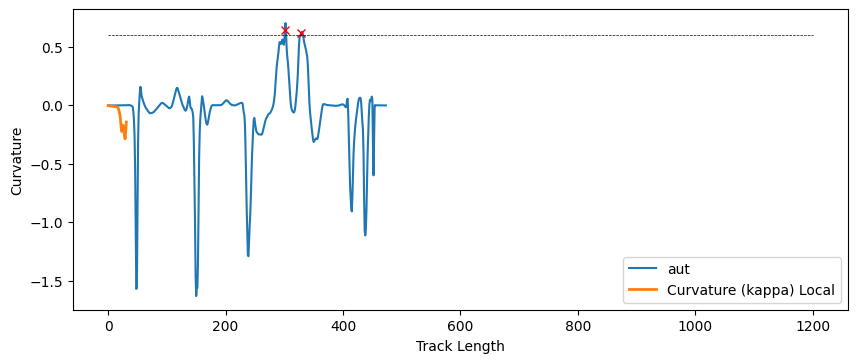

In [7]:
 # Load the boundary files
n = 520
local_track = np.load("../../Logs/LocalMPCC/RawData_mu60/LocalMapData_mu60/local_map_"+ str(n) +".npy")
map_names = map_df["Map name"].values
fig = plt.figure(figsize=(10, 3.9))

def count_corners(kappa, lower_threshold=0.2, corner_threshold=0.6):
    corner_count = 0
    valid_crossing = True
    corner_crossings = []
    for i in range(len(kappa) -1):
        if kappa[i] > corner_threshold and valid_crossing:
            corner_count += 1
            corner_crossings.append(i)
            valid_crossing = False
        if kappa[i] < lower_threshold:
            valid_crossing = True

    return corner_count, corner_crossings

def measure_straight_section(kappa, el_lengths_full, threshold=0.1):
    count = np.where(kappa < threshold)[0]
    straight_length = np.sum(el_lengths_full[count])

    return straight_length

local_x, local_y = local_track[:, 0], local_track[:, 1]
el_lengthsLocal = np.sqrt(np.sum(np.diff(local_track, axis=0)**2, axis=1))

psiLocal, kappaLocal = calc_head_curv_num(
        path=local_track,
        el_lengths=el_lengthsLocal,
        is_closed=False,
        stepsize_psi_preview=0.1,
        stepsize_psi_review=0.1,
        stepsize_curv_preview=0.2,
        stepsize_curv_review=0.2,
        calc_curv=True
    )

map_names = ["aut"]
for i, map_name in enumerate(map_names):
    centre_line = CentreLine(map_name.lower(), directory="../../maps/")  
    # kappa = np.abs(centre_line.kappa)
    kappa = centre_line.kappa
    corner_count, corner_crossings = count_corners(kappa)
    print(f"Corner count: {corner_count}")

    last_el = np.linalg.norm(centre_line.path[0] - centre_line.path[-1])
    full_el = np.append(centre_line.el_lengths, last_el)
    straight_length = measure_straight_section(kappa, full_el)
    print(f"Straight length: {straight_length} m")

    plt.plot(kappa, label=map_name)
    plt.plot(np.arange(len(kappaLocal)), kappaLocal, linewidth=2, label='Curvature (kappa) Local')
    plt.legend()
    plt.xlabel("Track Length")
    plt.ylabel("Curvature")
    plt.plot(corner_crossings, kappa[corner_crossings], 'rx')

    level = 0.6
    plt.plot([0, 1200], [level, level], 'k--', linewidth=.5)

Corner count: 2
Straight length: 83.66557754631953 m


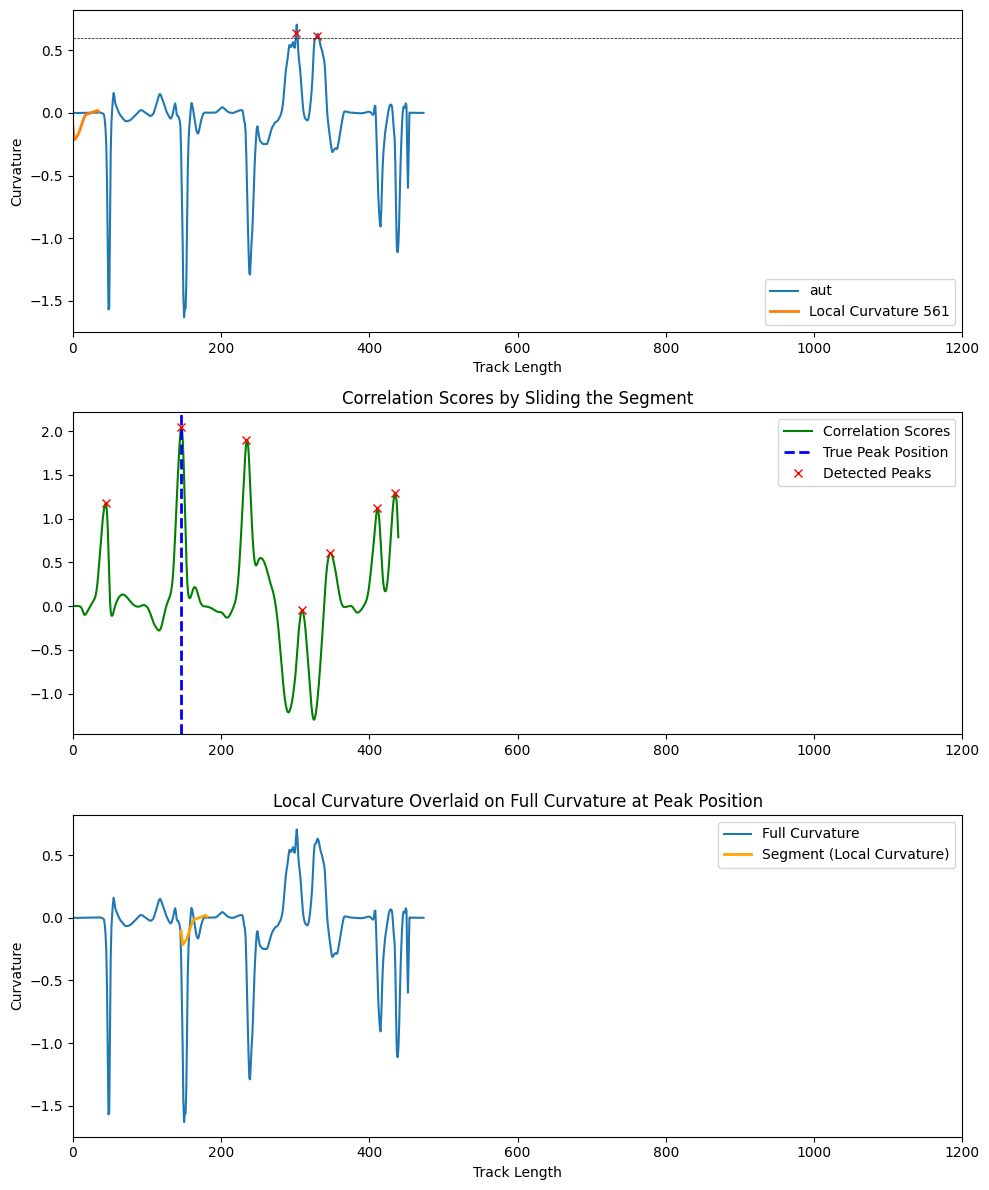

In [8]:
from scipy.signal import correlate, find_peaks

# Load the boundary files
# n = 520
n = 561
local_track = np.load("../../Logs/LocalMPCC/RawData_mu60/LocalMapData_mu60/local_map_"+ str(n) +".npy")
map_names = map_df["Map name"].values
fig, axs = plt.subplots(3, 1, figsize=(10, 12))  # 3 plots now

local_x, local_y = local_track[:, 0], local_track[:, 1]
el_lengthsLocal = np.sqrt(np.sum(np.diff(local_track, axis=0)**2, axis=1))

psiLocal, kappaLocal = calc_head_curv_num(
        path=local_track,
        el_lengths=el_lengthsLocal,
        is_closed=False,
        stepsize_psi_preview=0.1,
        stepsize_psi_review=0.1,
        stepsize_curv_preview=0.2,
        stepsize_curv_review=0.2,
        calc_curv=True
    )

map_names = ["aut"]
for i, map_name in enumerate(map_names):
    centre_line = CentreLine(map_name.lower(), directory="../../maps/")  
    kappa = centre_line.kappa
    corner_count, corner_crossings = count_corners(kappa)
    print(f"Corner count: {corner_count}")

    last_el = np.linalg.norm(centre_line.path[0] - centre_line.path[-1])
    full_el = np.append(centre_line.el_lengths, last_el)
    straight_length = measure_straight_section(kappa, full_el)
    print(f"Straight length: {straight_length} m")
    
    correlation_scores = np.correlate(kappa, kappaLocal, mode='valid')
    
    # Step 5: Find the peaks in the raw correlation scores using prominence
    peaks, properties = find_peaks(correlation_scores, prominence=0.5)  # Adjust prominence as needed

    # Find the peak closest to the actual segment position (for visualization purposes)
    actual_position_peak = np.argmax(correlation_scores)

    # Plot 1: Original curvature with local curvature overlay
    axs[0].plot(kappa, label=map_name)
    axs[0].plot(np.arange(len(kappaLocal)), kappaLocal, linewidth=2, label='Local Curvature '+ str(n))
    axs[0].legend()
    axs[0].set_xlabel("Track Length")
    axs[0].set_ylabel("Curvature")
    axs[0].plot(corner_crossings, kappa[corner_crossings], 'rx')
    axs[0].set_xlim(0, 1200)

    level = 0.6
    axs[0].plot([0, 1200], [level, level], 'k--', linewidth=.5)
    
    # Plot 2: Correlation scores
    shift_x = np.linspace(0, len(correlation_scores), len(correlation_scores))
    axs[1].plot(shift_x, correlation_scores, label="Correlation Scores", color='green')
    axs[1].axvline(actual_position_peak, color='blue', linestyle='--', label='True Peak Position', linewidth=2)
    axs[1].plot(peaks, correlation_scores[peaks], "x", label="Detected Peaks", color='red')
    axs[1].set_title("Correlation Scores by Sliding the Segment")
    axs[1].legend()
    axs[1].set_xlim(0, 1200)
    
    # Plot 3: Local curvature overlaid at peak correlation position
    start_index = actual_position_peak
    end_index = start_index + len(kappaLocal)
    
    axs[2].plot(kappa, label='Full Curvature')
    axs[2].plot(np.arange(start_index, end_index), kappaLocal, linewidth=2, label='Segment (Local Curvature)', color='orange')
    axs[2].set_title("Local Curvature Overlaid on Full Curvature at Peak Position")
    axs[2].legend()
    axs[2].set_xlabel("Track Length")
    axs[2].set_ylabel("Curvature")
    axs[2].set_xlim(0, 1200)

    plt.tight_layout()
    plt.show()


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

def plot_with_slider(n):
    # Load the boundary files based on the slider value for `n`
    local_track = np.load("../../Logs/LocalMPCC/RawData_mu60/LocalMapData_mu60/local_map_"+ str(n) +".npy")
    map_names = map_df["Map name"].values
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 3 plots now

    local_x, local_y = local_track[:, 0], local_track[:, 1]
    el_lengthsLocal = np.sqrt(np.sum(np.diff(local_track, axis=0)**2, axis=1))

    psiLocal, kappaLocal = calc_head_curv_num(
            path=local_track,
            el_lengths=el_lengthsLocal,
            is_closed=False,
            stepsize_psi_preview=0.1,
            stepsize_psi_review=0.1,
            stepsize_curv_preview=0.2,
            stepsize_curv_review=0.2,
            calc_curv=True
        )
    def interpolate_track_new(points, n_points=None, s=0):
        if len(points) <= 1:
            return points
        order_k = min(3, len(points) - 1)
        tck = interpolate.splprep([points[:, 0], points[:, 1]], k=order_k, s=s)[0]
        if n_points is None: n_points = len(points)
        track = np.array(interpolate.splev(np.linspace(0, 1, n_points), tck)).T
        return track

    def resample_track_points(points, seperation_distance=0.2, smoothing=0.2):
        if points[0, 0] > points[-1, 0]:
            points = np.flip(points, axis=0)

        line_length = np.sum(np.linalg.norm(np.diff(points, axis=0), axis=1))
        n_pts = max(int(line_length / seperation_distance), 2)
        smooth_line = interpolate_track_new(points, None, smoothing)
        resampled_points = interpolate_track_new(smooth_line, n_pts, 0)

        return resampled_points, smooth_line
    
   

    map_names = ["gbr"]
    for i, map_name in enumerate(map_names):
        centre_line = CentreLine(map_name.lower(), directory="../../maps/")  
        kappa = centre_line.kappa
        resampled_points, smooth_line = resample_track_points(centre_line.path, seperation_distance=0.2, smoothing=0.5)
        number_of_track_points = len(kappa)
        corner_count, corner_crossings = count_corners(kappa)
        print(f"Corner count: {corner_count}")

        last_el = np.linalg.norm(centre_line.path[0] - centre_line.path[-1])
        full_el = np.append(centre_line.el_lengths, last_el)
        straight_length = measure_straight_section(kappa, full_el)
        print(f"Straight length: {straight_length} m")
        
        

        el_lengthsSmooth = np.sqrt(np.sum(np.diff(smooth_line, axis=0)**2, axis=1))
        psiSmooth, kappaSmooth = calc_head_curv_num(
                path=smooth_line,
                el_lengths=el_lengthsSmooth,
                is_closed=False,
                stepsize_psi_preview=0.1,
                stepsize_psi_review=0.1,
                stepsize_curv_preview=0.2,
                stepsize_curv_review=0.2,
                calc_curv=True
            )

        el_lengthsSmooth2 = np.sqrt(np.sum(np.diff(resampled_points, axis=0)**2, axis=1))
        psiSmooth2, kappaSmooth2 = calc_head_curv_num(
                path=resampled_points,
                el_lengths=el_lengthsSmooth2,
                is_closed=False,
                stepsize_psi_preview=0.1,
                stepsize_psi_review=0.1,
                stepsize_curv_preview=0.2,
                stepsize_curv_review=0.2,
                calc_curv=True
            )
        
        correlation_scores = np.correlate(np.flip(-kappaSmooth2), kappaLocal, mode='valid')
        # correlation_scores = np.correlate(kappa, kappaLocal, mode='valid')
        
        # Step 5: Find the peaks in the raw correlation scores using prominence
        peaks, properties = find_peaks(correlation_scores, prominence=0.9)  # Adjust prominence as needed
        
        # Find the peak closest to the actual segment position (for visualization purposes)
        actual_position_peak = np.argmax(correlation_scores)

        # # Plot 1: Original curvature with local curvature overlay
        # axs[2].plot(kappa, label=map_name)
        # axs[2].plot(np.arange(len(kappaLocal)), kappaLocal, linewidth=2, label='Local Curvature '+ str(n))
        # axs[2].legend()
        # axs[2].set_xlabel("Track Length")
        # axs[2].set_ylabel("Curvature")
        # axs[2].plot(corner_crossings, kappa[corner_crossings], 'rx')
        # axs[2].set_xlim(0, 1200)

        # Plot 2: Correlation scores
        shift_x = np.linspace(0, len(correlation_scores), len(correlation_scores))
        axs[1].plot(shift_x, correlation_scores, label="Correlation Scores", color='green')
        axs[1].axvline(actual_position_peak, color='blue', linestyle='--', label='True Peak Position', linewidth=2)
        axs[1].plot(peaks, correlation_scores[peaks], "x", label="Detected Peaks", color='red')
        axs[1].set_title("Correlation Scores by Sliding the Segment")
        axs[1].legend()
        axs[1].set_xlim(0, number_of_track_points)
        axs[1].set_ylim(-5, 5)

        # Plot 3: Local curvature overlaid at peak correlation position
        start_index = actual_position_peak
        end_index = start_index + len(kappaLocal)
    
        axs[0].plot(kappa, label='Raw track Curvature')
        # axs[0].plot(np.flip(-kappaSmooth), label='Smooth track Curvature')
        axs[0].plot(np.flip(-kappaSmooth2), label='Resampled track Curvature')
        axs[0].plot(np.arange(start_index, end_index), kappaLocal, linewidth=2, label='Segment (Local Curvature)', color='red')
        axs[0].set_xlim(0, number_of_track_points)
        axs[0].set_title(f"Curvature of '{map_name}' track")
        axs[0].legend()

        plt.tight_layout()
        plt.show()

# Create an interactive slider for `n`
interact(plot_with_slider, n=IntSlider(min=0, max=1025, step=1, value=300));


interactive(children=(IntSlider(value=300, description='n', max=1025), Output()), _dom_classes=('widget-intera…

# Improving correlation precision
#### Options

1. *Normalization of Data*: Normalize both the larger set and the segment before calculating the correlation. This ensures that the correlation score reflects the shape more than the magnitude.

2. *Windowing*: Apply a Gaussian or other tapering window to the segment, reducing edge effects that can cause spurious correlations.

3. *Zero Padding*: Pad the segment with zeros at the ends, allowing it to match better with portions of the larger set that don’t have a high correlation.

4. *Cross-Correlation using scipy.signal.correlate*: Ensure we use the most precise correlation technique, with appropriate settings.

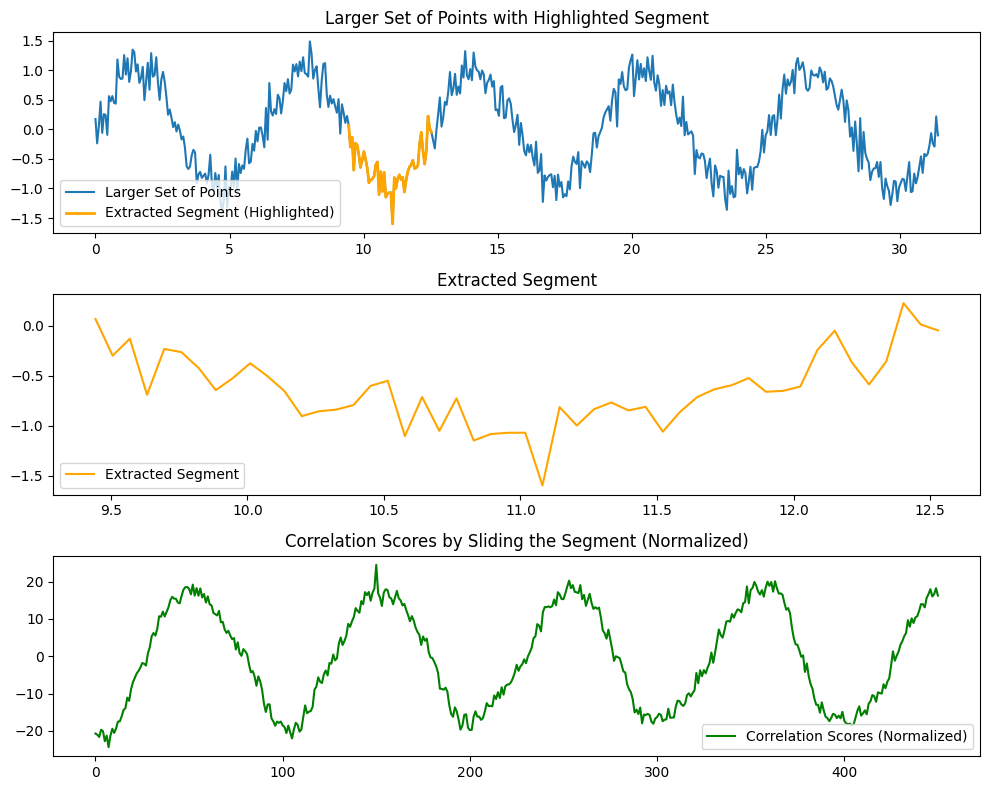

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Step 1: Generate a large set of points (e.g., noisy sine wave)
x = np.linspace(0, 10*np.pi, 500)
y = np.sin(x) + 0.2 * np.random.randn(len(x))  # Noisy sine wave

# Step 2: Extract a random segment
segment_start = 150
segment_length = 50
segment = y[segment_start:segment_start + segment_length]

# Step 3: Normalize both the larger set and the segment
y_normalized = (y - np.mean(y)) / np.std(y)
segment_normalized = (segment - np.mean(segment)) / np.std(segment)

# Step 4: Compute cross-correlation by sliding the normalized segment over the normalized larger set
correlation_scores = correlate(y_normalized, segment_normalized, mode='valid')

# Step 5: Visualization
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Plot the larger set of points and highlight the segment
axs[0].plot(x, y, label="Larger Set of Points")
axs[0].plot(x[segment_start:segment_start + segment_length], segment, label="Extracted Segment (Highlighted)", color='orange', linewidth=2)
axs[0].set_title("Larger Set of Points with Highlighted Segment")
axs[0].legend()

# Plot the extracted segment
segment_x = x[segment_start:segment_start + segment_length]
axs[1].plot(segment_x, segment, label="Extracted Segment", color='orange')
axs[1].set_title("Extracted Segment")
axs[1].legend()

# Plot normalized correlation scores as the segment slides
shift_x = np.arange(len(correlation_scores))
axs[2].plot(shift_x, correlation_scores, label="Correlation Scores (Normalized)", color='green')
axs[2].set_title("Correlation Scores by Sliding the Segment (Normalized)")
axs[2].legend()

plt.tight_layout()
plt.show()


/tmp/ipykernel_168179/4014658757.py:23: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smoothed_correlation_scores = filters.gaussian_filter1d(correlation_scores, sigma=2)


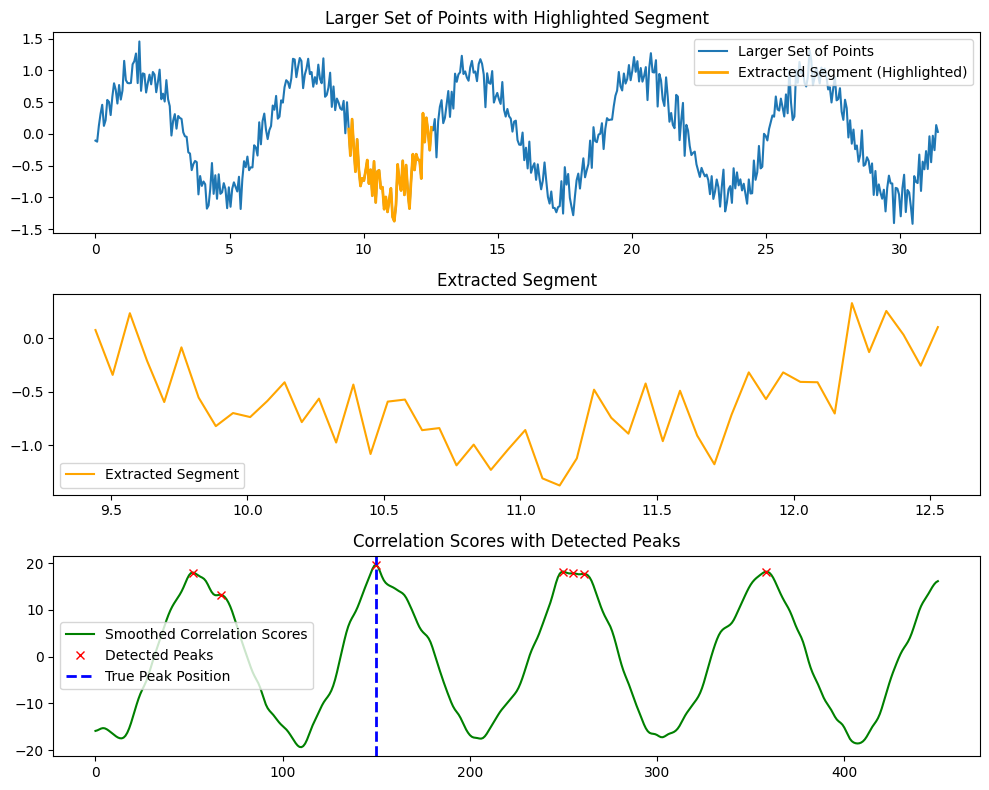

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, find_peaks, gaussian
from scipy.ndimage import filters

# Step 1: Generate a large set of points (e.g., noisy sine wave)
x = np.linspace(0, 10*np.pi, 500)
y = np.sin(x) + 0.2 * np.random.randn(len(x))  # Noisy sine wave

# Step 2: Extract a random segment
segment_start = 150
segment_length = 50
segment = y[segment_start:segment_start + segment_length]

# Step 3: Normalize both the larger set and the segment
y_normalized = (y - np.mean(y)) / np.std(y)
segment_normalized = (segment - np.mean(segment)) / np.std(segment)

# Step 4: Compute cross-correlation by sliding the normalized segment over the normalized larger set
correlation_scores = correlate(y_normalized, segment_normalized, mode='valid')

# Step 5: Apply Gaussian smoothing to the correlation scores to reduce noise
smoothed_correlation_scores = filters.gaussian_filter1d(correlation_scores, sigma=2)

# Step 6: Find the peaks in the smoothed correlation scores
peaks, _ = find_peaks(smoothed_correlation_scores, height=0.5)  # Adjust height threshold as needed

# Find the peak closest to the actual segment position (for visualization purposes)
actual_position_peak = np.argmax(smoothed_correlation_scores)

# Step 7: Visualization
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Plot the larger set of points and highlight the segment
axs[0].plot(x, y, label="Larger Set of Points")
axs[0].plot(x[segment_start:segment_start + segment_length], segment, label="Extracted Segment (Highlighted)", color='orange', linewidth=2)
axs[0].set_title("Larger Set of Points with Highlighted Segment")
axs[0].legend()

# Plot the extracted segment
segment_x = x[segment_start:segment_start + segment_length]
axs[1].plot(segment_x, segment, label="Extracted Segment", color='orange')
axs[1].set_title("Extracted Segment")
axs[1].legend()

# Plot smoothed correlation scores and mark the detected peaks
shift_x = np.arange(len(smoothed_correlation_scores))
axs[2].plot(shift_x, smoothed_correlation_scores, label="Smoothed Correlation Scores", color='green')
axs[2].plot(peaks, smoothed_correlation_scores[peaks], "x", label="Detected Peaks", color='red')
axs[2].axvline(actual_position_peak, color='blue', linestyle='--', label='True Peak Position', linewidth=2)
axs[2].set_title("Correlation Scores with Detected Peaks")
axs[2].legend()

plt.tight_layout()
plt.show()


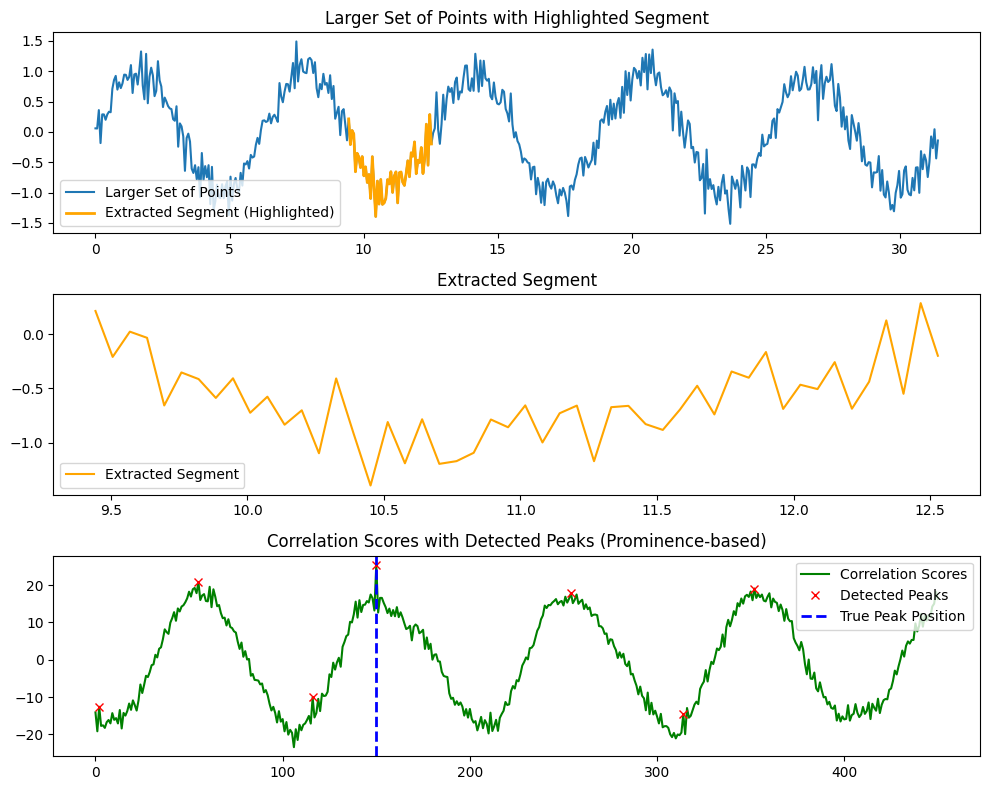

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, find_peaks

# Step 1: Generate a large set of points (e.g., noisy sine wave)
x = np.linspace(0, 10*np.pi, 500)
y = np.sin(x) + 0.2 * np.random.randn(len(x))  # Noisy sine wave

# Step 2: Extract a random segment
segment_start = 150
segment_length = 50
segment = y[segment_start:segment_start + segment_length]

# Step 3: Normalize both the larger set and the segment
y_normalized = (y - np.mean(y)) / np.std(y)
segment_normalized = (segment - np.mean(segment)) / np.std(segment)

# Step 4: Compute cross-correlation by sliding the normalized segment over the normalized larger set
correlation_scores = correlate(y_normalized, segment_normalized, mode='valid')

# Step 5: Find the peaks in the raw correlation scores using prominence
peaks, properties = find_peaks(correlation_scores, prominence=5)  # Adjust prominence as needed

# Find the peak closest to the actual segment position (for visualization purposes)
actual_position_peak = np.argmax(correlation_scores)

# Step 6: Visualization
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Plot the larger set of points and highlight the segment
axs[0].plot(x, y, label="Larger Set of Points")
axs[0].plot(x[segment_start:segment_start + segment_length], segment, label="Extracted Segment (Highlighted)", color='orange', linewidth=2)
axs[0].set_title("Larger Set of Points with Highlighted Segment")
axs[0].legend()

# Plot the extracted segment
segment_x = x[segment_start:segment_start + segment_length]
axs[1].plot(segment_x, segment, label="Extracted Segment", color='orange')
axs[1].set_title("Extracted Segment")
axs[1].legend()

# Plot raw correlation scores and mark the detected peaks
shift_x = np.arange(len(correlation_scores))
axs[2].plot(shift_x, correlation_scores, label="Correlation Scores", color='green')
axs[2].plot(peaks, correlation_scores[peaks], "x", label="Detected Peaks", color='red')
axs[2].axvline(actual_position_peak, color='blue', linestyle='--', label='True Peak Position', linewidth=2)
axs[2].set_title("Correlation Scores with Detected Peaks (Prominence-based)")
axs[2].legend()

plt.tight_layout()
plt.show()


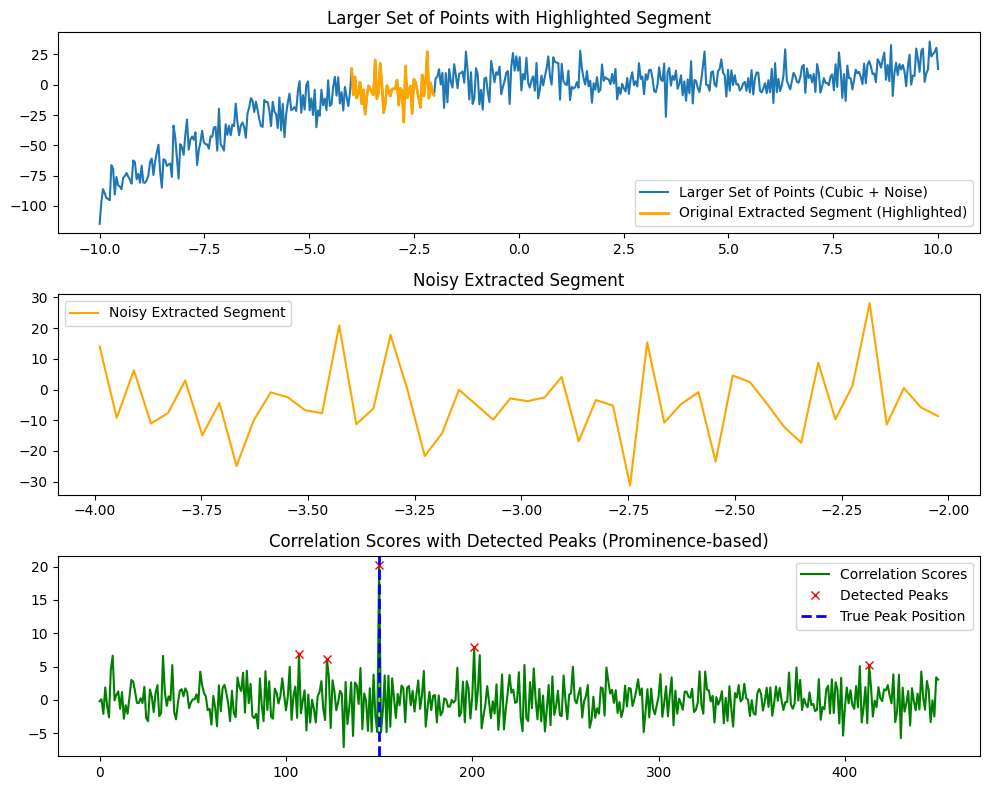

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, find_peaks

# Step 1: Generate a non-periodic cubic polynomial function (e.g., y = ax^3 + bx^2 + cx + d)
x = np.linspace(-10, 10, 500)
y = 0.05*x**3 - 0.4*x**2 + 0.6*x + 3 + 10 * np.random.randn(len(x))  # Add noise to the cubic function

# Step 2: Extract a random segment and add extra noise to it
segment_start = 150
segment_length = 50
segment = y[segment_start:segment_start + segment_length]
segment_noisy = segment + 0.5 * np.random.randn(segment_length)  # Add extra noise to the segment

# Step 3: Normalize both the larger set and the noisy segment
y_normalized = (y - np.mean(y)) / np.std(y)
segment_normalized = (segment_noisy - np.mean(segment_noisy)) / np.std(segment_noisy)

# Step 4: Compute cross-correlation by sliding the normalized noisy segment over the normalized larger set
correlation_scores = correlate(y_normalized, segment_normalized, mode='valid')

# Step 5: Find the peaks in the raw correlation scores using prominence
peaks, properties = find_peaks(correlation_scores, prominence=10)  # Adjust prominence as needed

# Find the peak closest to the actual segment position (for visualization purposes)
actual_position_peak = np.argmax(correlation_scores)

# Step 6: Visualization
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Plot the larger set of points and highlight the segment
axs[0].plot(x, y, label="Larger Set of Points (Cubic + Noise)")
axs[0].plot(x[segment_start:segment_start + segment_length], segment, label="Original Extracted Segment (Highlighted)", color='orange', linewidth=2)
axs[0].set_title("Larger Set of Points with Highlighted Segment")
axs[0].legend()

# Plot the noisy extracted segment
segment_x = x[segment_start:segment_start + segment_length]
axs[1].plot(segment_x, segment_noisy, label="Noisy Extracted Segment", color='orange')
axs[1].set_title("Noisy Extracted Segment")
axs[1].legend()

# Plot raw correlation scores and mark the detected peaks
shift_x = np.arange(len(correlation_scores))
axs[2].plot(shift_x, correlation_scores, label="Correlation Scores", color='green')
axs[2].plot(peaks, correlation_scores[peaks], "x", label="Detected Peaks", color='red')
axs[2].axvline(actual_position_peak, color='blue', linestyle='--', label='True Peak Position', linewidth=2)
axs[2].set_title("Correlation Scores with Detected Peaks (Prominence-based)")
axs[2].legend()

plt.tight_layout()
plt.show()
